In [1]:
from numpy import random
from IPython.display import clear_output
import time
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation
from statsmodels.stats.stattools import durbin_watson
from scipy import ndimage

In [2]:
def life_step(X):
    
    """Game of life step using generator expressions"""
    
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

In [3]:
def life_animation(X, dpi=80, frames=10, interval=300, mode='loop'):
    
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(int) 
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)  
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(-0.05, 10)
    
    # initialization function: plot the background of each frame
    
    def init():
        
        im.set_data(X_blank)
        return (im,)
    
    # animation function.  This is called sequentially
    
    def animate(i):
        
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        
        return (im,)
    
    animate.X = X
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval)
    
    return display_animation(anim, default_mode=mode)      

In [4]:
def add_border(x, border = 3):
        
        offset = int((border - 1)/2)
        
        background = np.repeat(0, x.shape[0] * x.shape[1] * border * border).reshape([x.shape[0] * border, x.shape[1] * border])
        background[x.shape[0]*offset:-x.shape[0]*offset, x.shape[1]*offset:-x.shape[1]*offset] = x
        
        return(background)

In [5]:
def sig_func(x,y):
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [6]:
def con_run(frame_n = 100,
            start_pop = 50,
            xd = 10,
            yd = 10,
            sample_n = 10,
            top_fraction = 0.1,
            border = 3):
    
    first_frames = []
    scores = []
    trials = int(sample_n/top_fraction)
    
    for i in range(trials):
    
        coords = np.append(random.choice(range(xd),start_pop),
                           random.choice(range(yd),start_pop)).reshape(start_pop,2)
        
        a = np.repeat(0,xd*yd).reshape([xd,yd])
        
        for i in range(start_pop):
            
            a[coords[i][0],coords[i][1]] = 1
            
        b = add_border(a, border)

        for i in range(frame_n-1):
            
            c = life_step(b.reshape([i+1,xd*border, yd*border])[i,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*border, yd*border)
        
        dw_score = abs((durbin_watson(np.sum(b.reshape([frame_n, xd*border*yd*border]), axis=1).tolist())-2)/2)
        
        cm_score = np.var(ndimage.center_of_mass(b))
        
        score = dw_score*np.log(cm_score)
        print(score)

        scores = np.append(scores,score)
        
        first_frames = np.append(first_frames, a.flatten())
   
    top_scores_index = np.argsort(scores)[::-1][:sample_n]
    top_scores = scores[top_scores_index]
    top_first_frames = first_frames.reshape([trials, xd*yd])[top_scores_index]

    return(top_first_frames,top_scores)

In [7]:
def train_des(des_training_inputs,
              des_training_outputs,
              des_weights,
              iteration_n):
    
    for i in range(iteration_n):
        
        result = sig_func(des_training_inputs, des_weights)
        des_weights += np.dot(des_training_inputs.T,
                              (des_training_outputs - result) *
                              result *
                              (1 - result))
        
    return(des_weights)

In [85]:
iteration_n = 10

frame_n = 100
xd = 6
yd = 6
sample_n = 50
half_n =25
top_fraction = 0.1
border = 5
top_n = 5

gen_noise = random.choice([0,1], [sample_n, xd*yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1
des_weights = 2 * random.random((xd*yd, 1)) - 1
    
for i in range(iteration_n):
    # Generate
    generated = sig_func(gen_noise, gen_weights)
    print("generated")
    print(generated.shape)

    # Evaluate

    evaluated = []

    for i in range(sample_n):

        b = add_border(generated[i].reshape([xd, yd]), border)


        for j in range(frame_n-1):

            c = life_step(b.reshape([j+1,xd*border, yd*border])[j,:]).flatten()
            b = np.append(b,c)

        b = b.reshape(frame_n, xd*border, yd*border)

        dw_score = abs((durbin_watson(np.sum(b.reshape([frame_n, xd*border*yd*border]), axis=1).tolist())-2)/2)
        cm_score = np.var(ndimage.center_of_mass(b))
        score = dw_score*np.log(cm_score)
        evaluated = np.append(evaluated,score)
        
    evaluated = evaluated.reshape([sample_n,1])   
    print("evaluated")
    print(evaluated.shape)


    #Descriminate
    descriminated = sig_func(generated, des_weights)
    print("descriminated")
    print(descriminated.shape)
    des_weights += np.dot(generated.T,
                          (evaluated - descriminated) * descriminated * (1 - descriminated))

    #top_scores_index = np.argsort(descriminated.flatten())[::-1][:int(sample_n/2)]
    #bottom_scores_index = np.argsort(descriminated.flatten())[:int(sample_n/2)]
    #top_scores = descriminated[top_scores_index]
    #top_first_frames = generated[top_scores_index]







    result = np.argsort(sig_func(generated, des_weights)).flatten()
    top = result[::-1][:half_n]
    bottom = result[:half_n]

    gen_weights += np.dot(gen_noise[top].T,
                          (generated[top] - generated[bottom]) * generated[bottom] * (1 - generated[bottom]))


gen_result = sig_func(gen_noise, gen_weights)
im = np.unique(np.round(gen_result), axis=0)
score = sig_func(im, des_weights)
top_ind = np.argsort(score)[::-1][0]
top_score = score[top_ind]
top_im = im[top_ind].reshape([xd,yd])

clear_output(wait=True)
print(top_im)
print(top_score)
        
        
        

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 0.]]
[[nan]]


In [9]:
iteration_n = 1000

frame_n = 100
start_pop = 6
xd = 6
yd = 6
sample_n = 50
top_fraction = 0.1
border = 5


des_td = con_run(frame_n = frame_n,
                 start_pop = start_pop,
                 xd = xd,
                 yd = yd,
                 sample_n = sample_n,
                 top_fraction = top_fraction,
                 border = border,
)

des_training_inputs = des_td[0]
des_training_outputs = des_td[1].reshape(sample_n,1)
des_weights = 2 * random.random((des_training_inputs.shape[1],
                                 des_training_outputs.shape[1])) - 1


gen_noise = random.choice([0,1], [sample_n, xd * yd])
gen_weights = 2 * random.random((xd*yd, xd*yd)) - 1


des_weights = train_des(des_training_inputs,
                        des_training_outputs,
                        des_weights,
                        iteration_n)

gen_weights = train_gen(gen_noise,
                        gen_weights,
                        des_weights,
                        iteration_n)

gen_result = sig_func(gen_noise, gen_weights)

im = np.unique(np.round(gen_result), axis=0)
score = sig_func(im, des_weights)
top_ind = np.argsort(score)[::-1][0]
top_score = score[top_ind]
top_im = im[top_ind].reshape([xd,yd])

clear_output(wait=True)
print(top_im)
print(top_score)

[[1. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 0.]]
[[1.]]



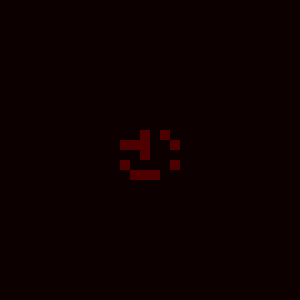
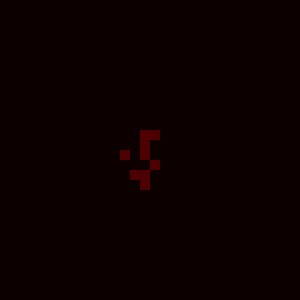
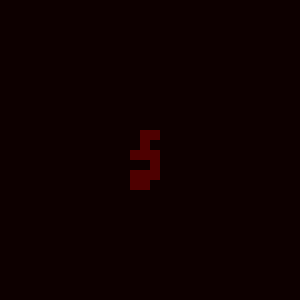
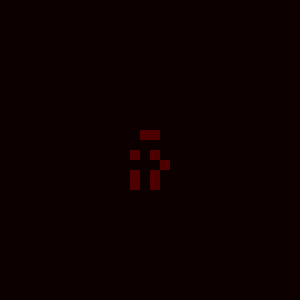
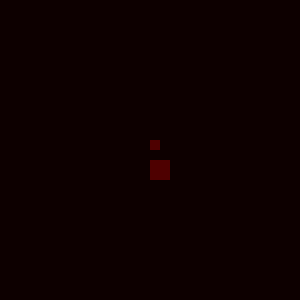
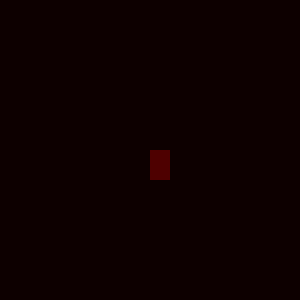
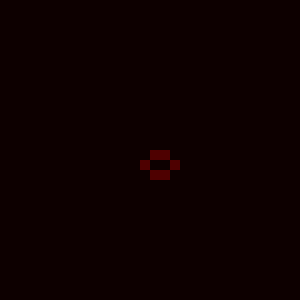
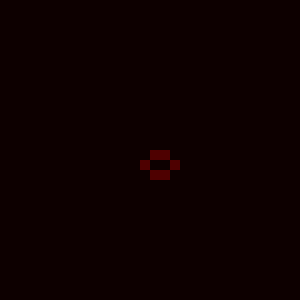
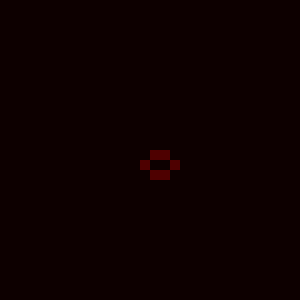
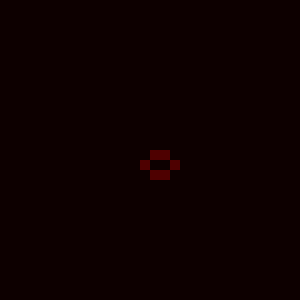
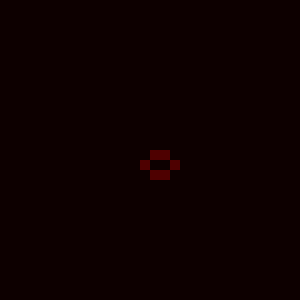
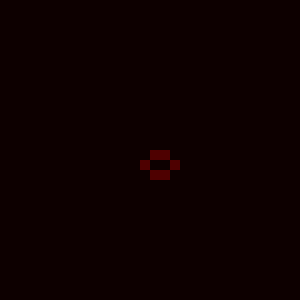
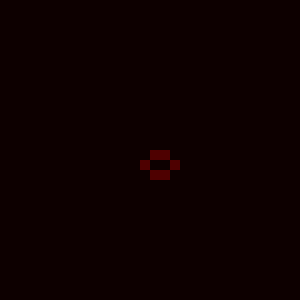
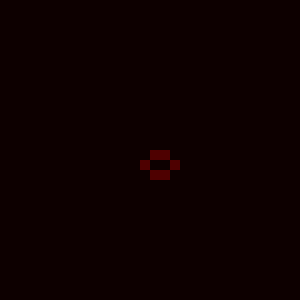
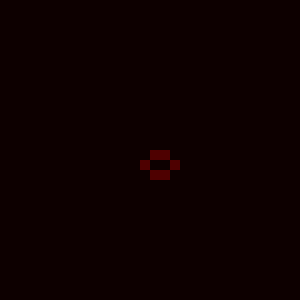
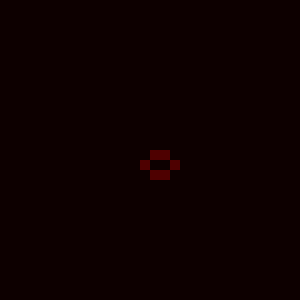
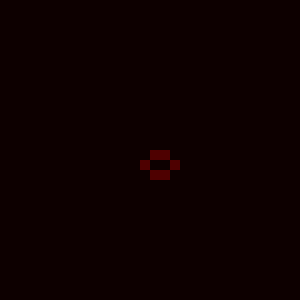
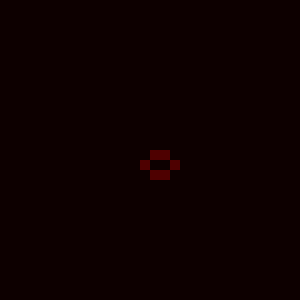
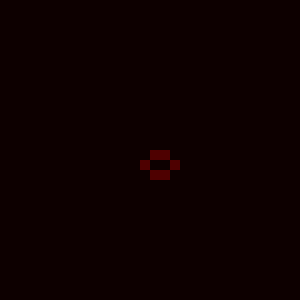
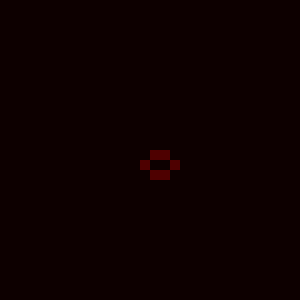
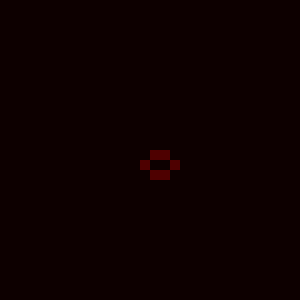
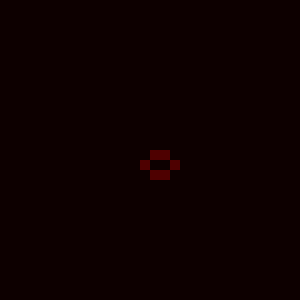
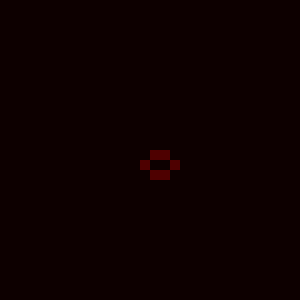
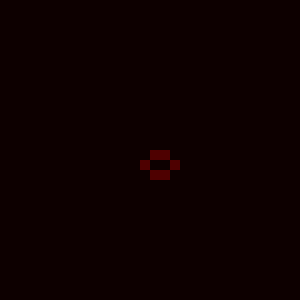
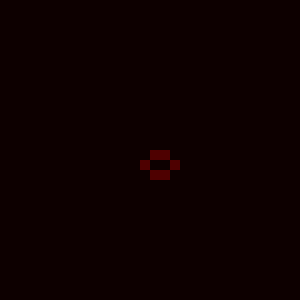
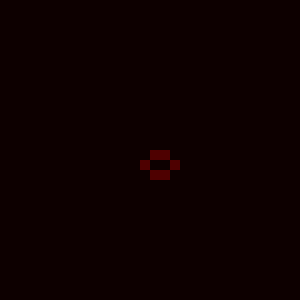
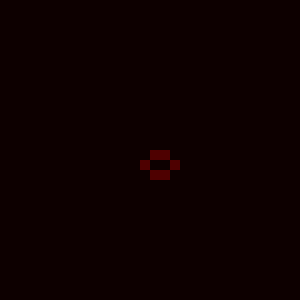
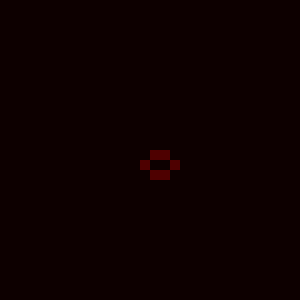
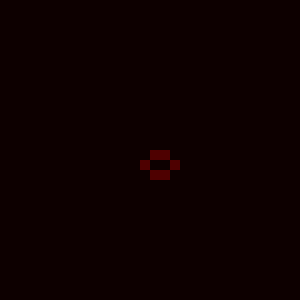
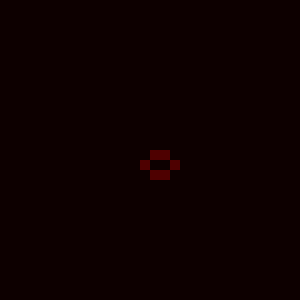
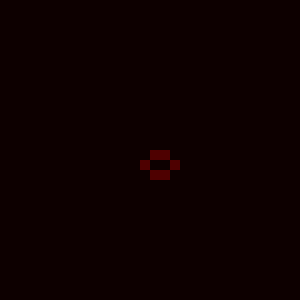
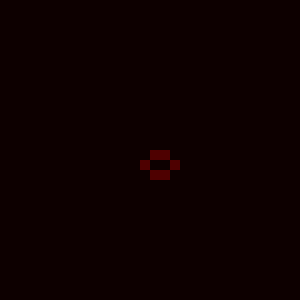
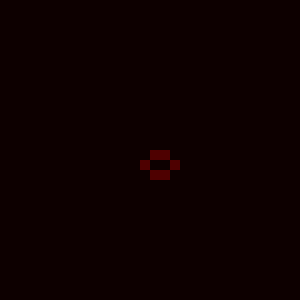
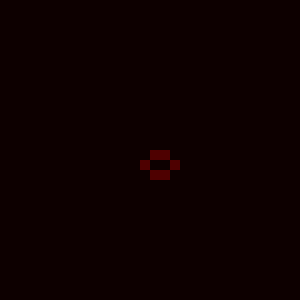
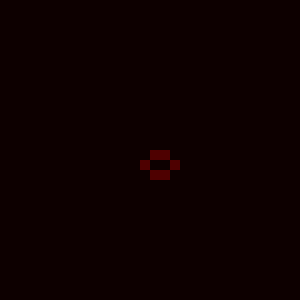
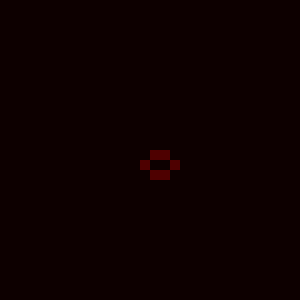
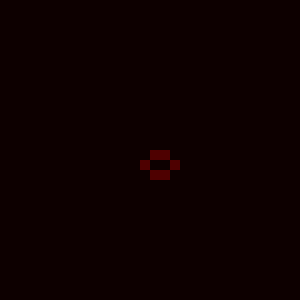
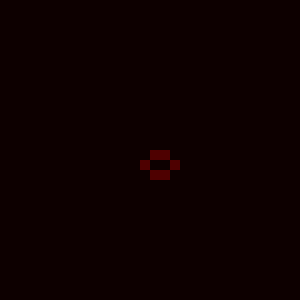
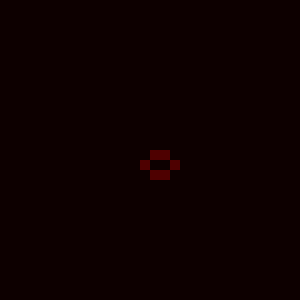
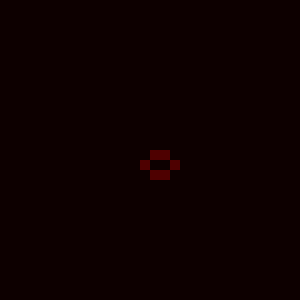
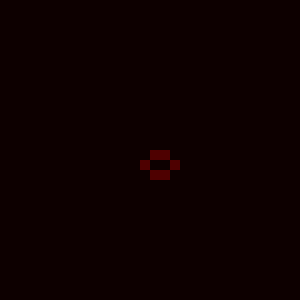
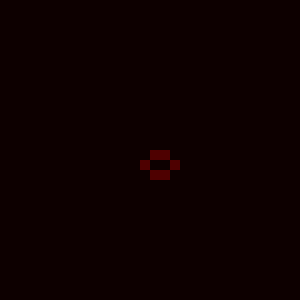
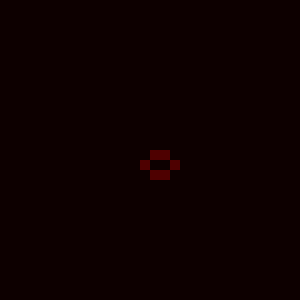
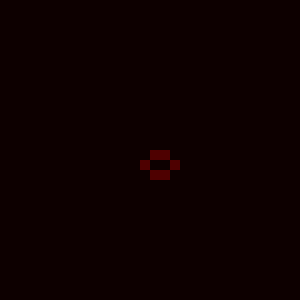
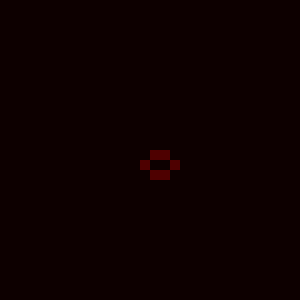
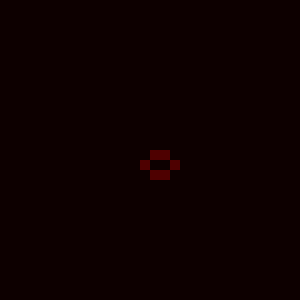
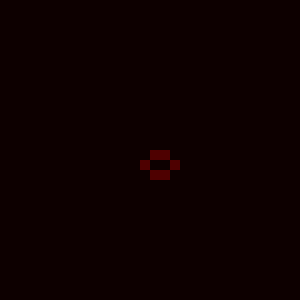
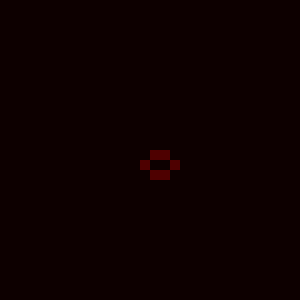
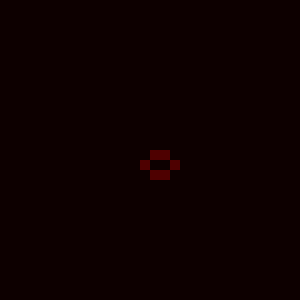
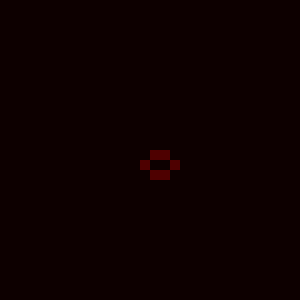
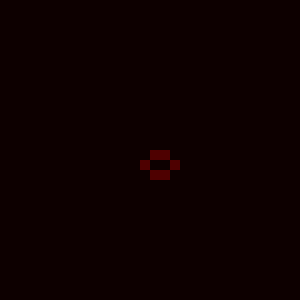
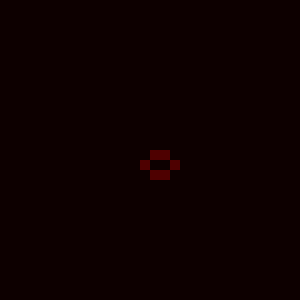
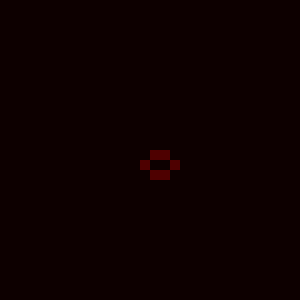
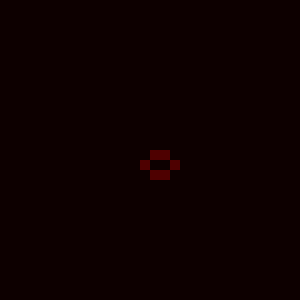
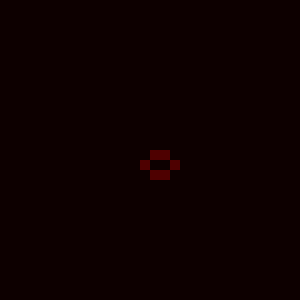
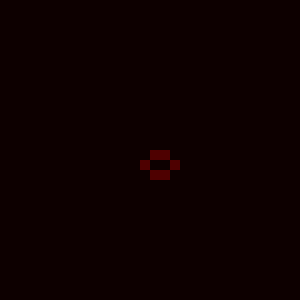
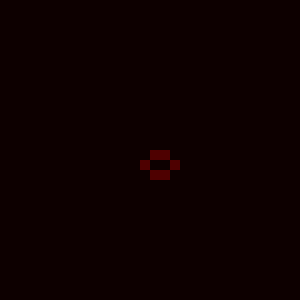
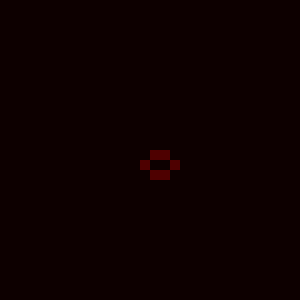
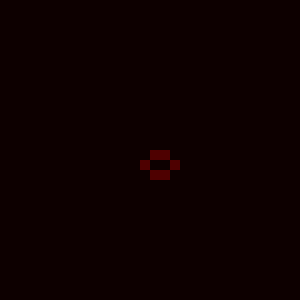
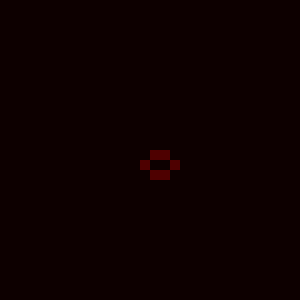
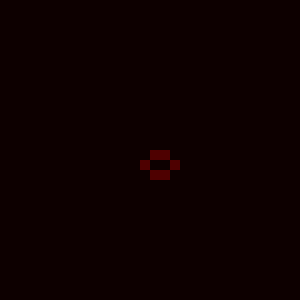
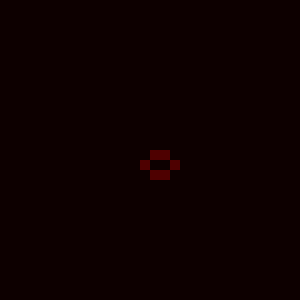
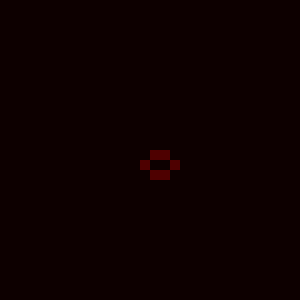
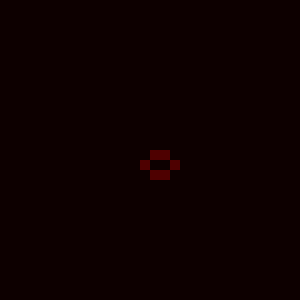
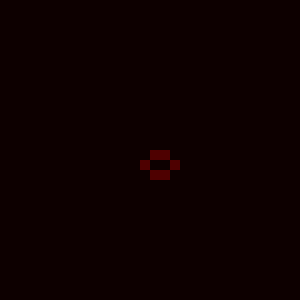
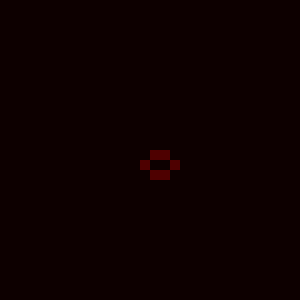
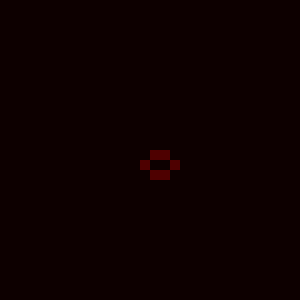
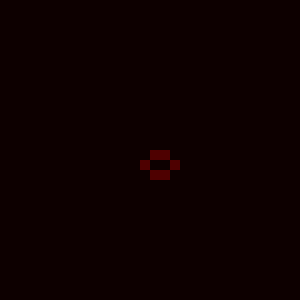
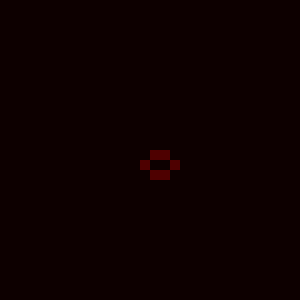
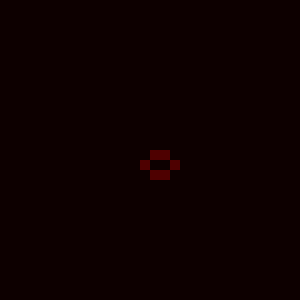
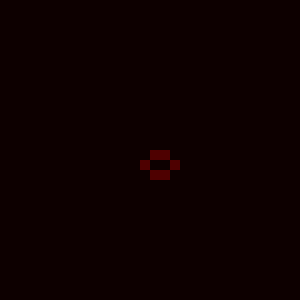
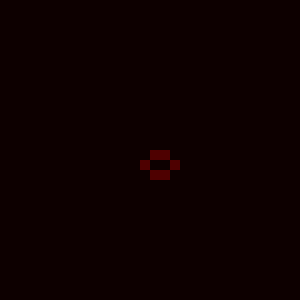
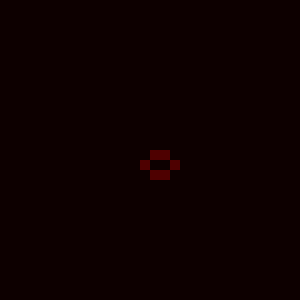
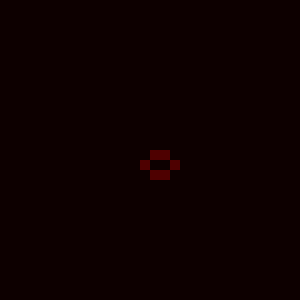
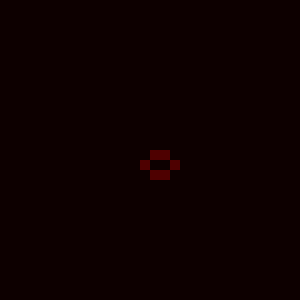
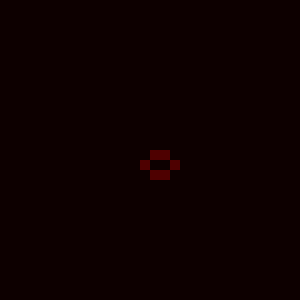
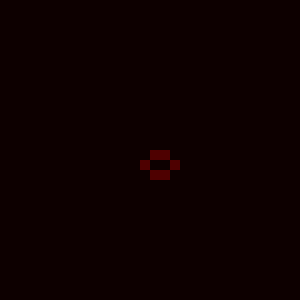
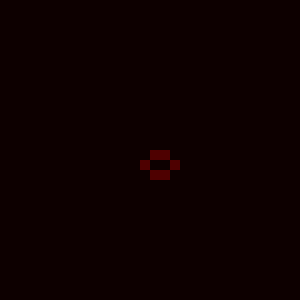
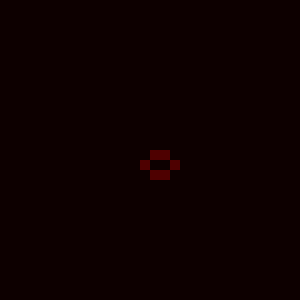
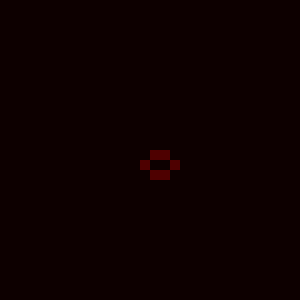
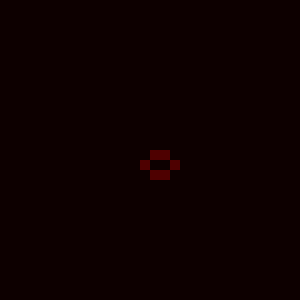
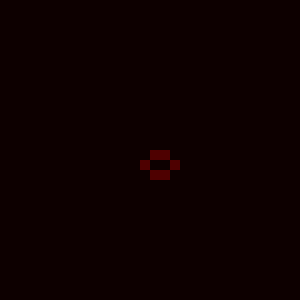
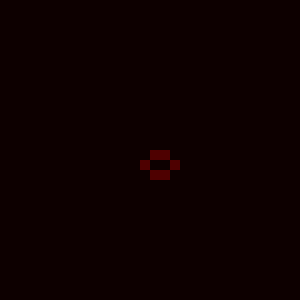
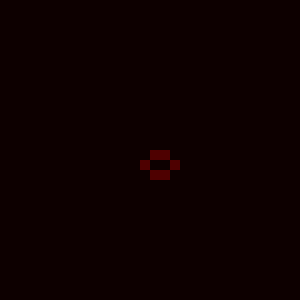
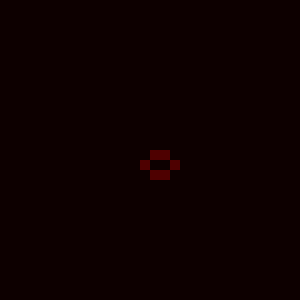
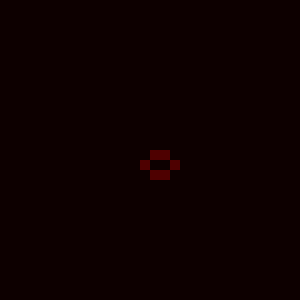
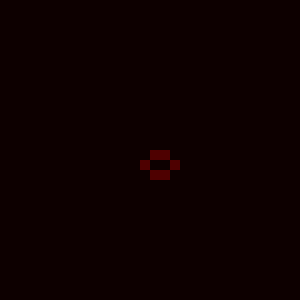
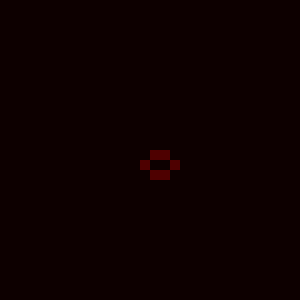
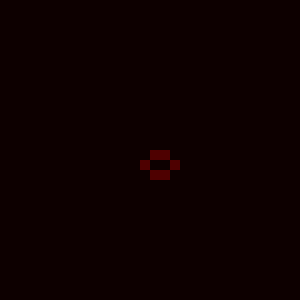
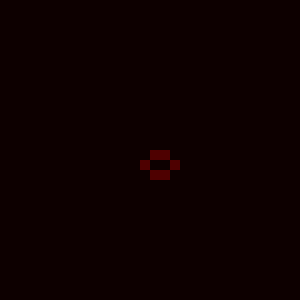
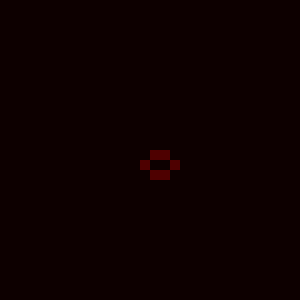
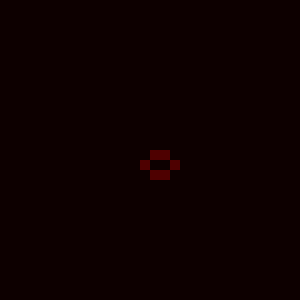
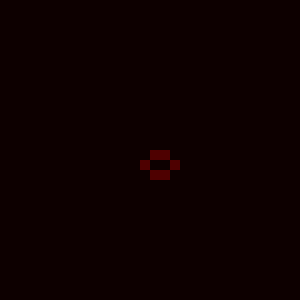
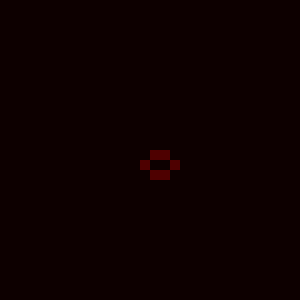
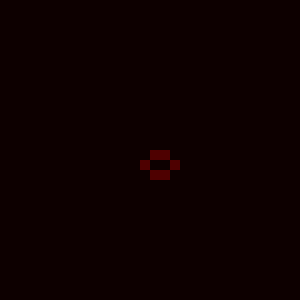
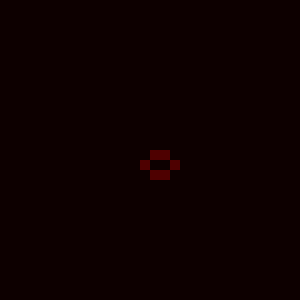
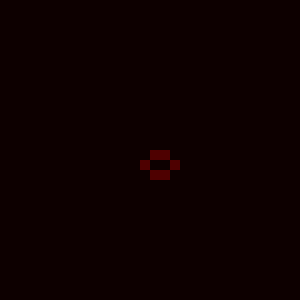
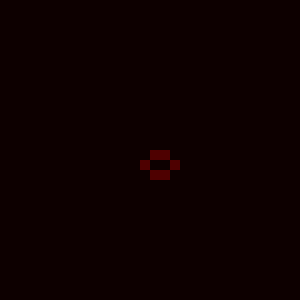
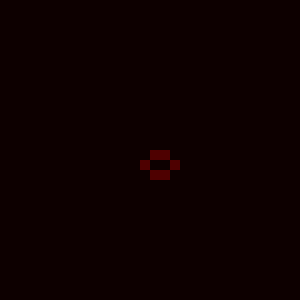
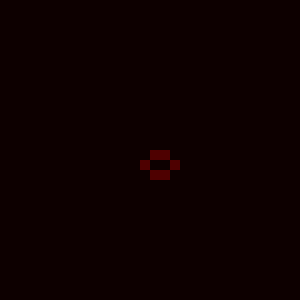

In [86]:
life_animation(add_border(top_im, 5), dpi=15, frames=frame_n, interval=50, mode='once')